**Remarks**

In this notebook, we will learn about spam-rating-indicator. Yeayy! I used this APIS dataset in e-commerce. Let's started!

In [41]:
# import library
# 1. NLP tools
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import unicodedata
import en_core_web_sm
from textblob import TextBlob

# 2. Preprocessing tools
import pandas as pd
import requests
from tqdm import tqdm
import sys
import os
import json
from bs4 import BeautifulSoup

# 3. Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC

In [7]:
# extracting data from HTML tags
dataset_1 = []

# iterating for 50 pages of reviews
for i in tqdm(range(1,50)):
  URL = f"https://www.flipkart.com/realme-c21-cross-blue-64-gb/product-reviews/itmf4062d3f37c1a?pid=MOBGF4895YRNAHFZ&lid=LSTMOBGF4895YRNAHFZ3XABXU&marketplace=FLIPKART&page={i}"  
  r = requests.get(URL)
  soup = BeautifulSoup(r.content, 'html.parser')

  cols = soup.find_all('div', attrs={'class':'col _2wzgFH K0kLPL'})

  for col in cols:
    row = col.find_all('div',attrs={'class':'row'})
    rating = row[0].find('div').text
    review = row[1].find('div').text
  
    dataset_1.append({'review': review , 'rating' : rating})

print("\nMenghitung jumlah dataset", len(dataset_1))

100%|██████████| 49/49 [01:27<00:00,  1.79s/it]


Menghitung jumlah dataset 436


In [8]:
# extracting data from HTML tags
dataset_2 = []

# iterating for 50 pages of reviews
for i in tqdm(range(1,50)):
  URL = f"https://www.flipkart.com/realme-x-polar-white-128-gb/product-reviews/itmfgybqzcgbxs26?pid=MOBFGYBQF4HYB25W&lid=LSTMOBFGYBQF4HYB25WZATDKH&marketplace=FLIPKART&page={i}"  
  r = requests.get(URL)
  soup = BeautifulSoup(r.content, 'html.parser')

  cols = soup.find_all('div', attrs={'class':'col _2wzgFH K0kLPL'})

  for col in cols:
    row = col.find_all('div',attrs={'class':'row'})
    rating = row[0].find('div').text
    review = row[1].find('div').text
  
    dataset_2.append({'review': review , 'rating' : rating})

print("\nMenghitung jumlah dataset", len(dataset_2))

100%|██████████| 49/49 [01:40<00:00,  2.04s/it]


Menghitung jumlah dataset 490


In [9]:
# extracting data from HTML tags
dataset_3 = []

# iterating for 50 pages of reviews
for i in tqdm(range(1,50)):
  URL = f"https://www.flipkart.com/realme-c21-cross-black-32-gb/product-reviews/itmf4062d3f37c1a?pid=MOBGF489EUA5PEBK&lid=LSTMOBGF489EUA5PEBKOSO80O&marketplace=FLIPKART&page={i}"  
  r = requests.get(URL)
  soup = BeautifulSoup(r.content, 'html.parser')

  cols = soup.find_all('div', attrs={'class':'col _2wzgFH K0kLPL'})

  for col in cols:
    row = col.find_all('div',attrs={'class':'row'})
    rating = row[0].find('div').text
    review = row[1].find('div').text
  
    dataset_3.append({'review': review , 'rating' : rating})

print("\nMenghitung jumlah dataset", len(dataset_3))

100%|██████████| 49/49 [01:33<00:00,  1.90s/it]


Menghitung jumlah dataset 435


In [10]:
# saving into dataframe
df_1 = pd.DataFrame(dataset_1)
df_2 = pd.DataFrame(dataset_2)
df_3 = pd.DataFrame(dataset_3)

df = pd.concat([df_1, df_2, df_3], axis=0).reset_index(drop=True)
df.head()

,review,rating
0,"Really nice phone, delivery is so fast that's ...",5
1,Really I m in love wth this mobileMobile is ni...,5
2,Nice 👍😍 very nice fast delivery 🚚 Flipkart nic...,3
3,realme C21 Camera is not good music is a bit g...,3
4,Very nice phone very powerful process but came...,4


In [11]:
print("Shape of dataframe", df.shape)

Shape of dataframe (1361, 2)


In [12]:
print("Information dataset")
df.info()

Information dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361 entries, 0 to 1360
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1361 non-null   object
 1   rating  1361 non-null   object
dtypes: object(2)
memory usage: 21.4+ KB


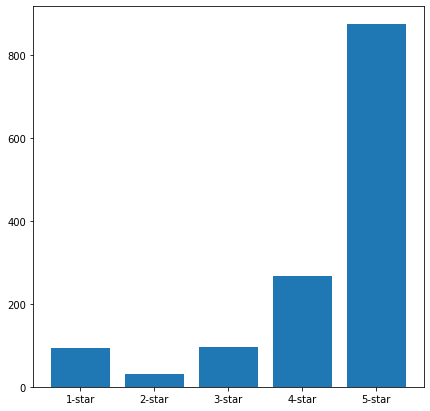

In [17]:
# changing type rating
df.rating = df.rating.astype(int)
plt.figure(figsize=(7,7))
ratings = ['1-star', '2-star', '3-star', '4-star', '5-star']
numrank = [len(df[df.rating == 1]),
           len(df[df.rating == 2]),
           len(df[df.rating == 3]),
           len(df[df.rating == 4]),
           len(df[df.rating == 5])]
plt.bar(ratings, numrank)
plt.show();

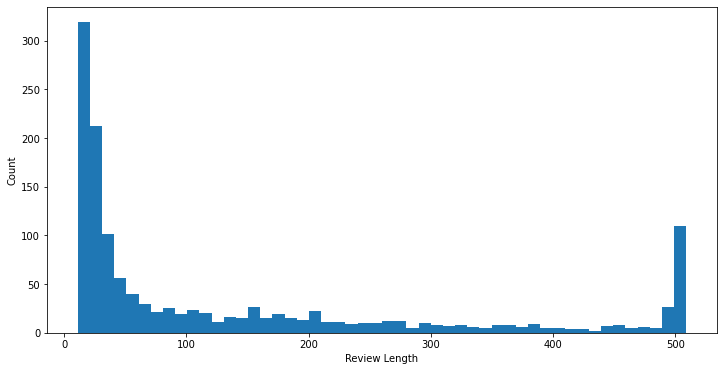

In [20]:
# distribution of length
review_length = pd.DataFrame(df.review.str.len())
review_length = review_length[review_length.review < 5000]
review_length.groupby(['review'])
review_length = review_length.plot(kind='hist', legend=None,
                                   bins=50, figsize=(12,6))
review_length.set_xlabel("Review Length")
review_length.set_ylabel("Count");

In [30]:
# cleaning data
nlp = en_core_web_sm.load()

def get_wordcounts(x):
  length = len(str(x).split())
  return length

def get_charcounts(x):
  s = x.split()
  x = ''.join(s)
  return len(x)

def get_avg_wordlength(x):
  count = get_charcounts(x)/get_wordcounts(x)
  return count

def get_stopwords_counts(x):
  l = len([t for t in x.split() if t in stopwords])
  return l

def get_hashtag_counts(x):
  l = len([t for t in x.split() if t.startswith('#')])
  return l

def get_mentions_counts(x):
  l = len([t for t in x.split() if t.startswith('@')])
  return l

def get_digit_counts(x):
  digits = re.findall(r'[0-9,.]+', x)
  return len(digits)

def get_uppercase_counts(x):
  l = len([t for t in x.split() if t.isupper()])
  return l

def get_emails(x):
  emails = re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', x)
  counts = len(emails)
  return counts, emails

def remove_emails(x):
  remove = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)
  return remove

def get_urls(x):
  urls = re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)
  counts = len(urls)
  return counts, urls

def remove_urls(x):
  remove = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)
  return remove

def remove_rt(x):
  rt = re.sub(r'\brt\b', '', x).strip()
  return rt

def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

def remove_html_tags(x):
  remove = BeautifulSoup(x, 'lxml').get_text().strip()
  return remove

def remove_accented_chars(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return x

def remove_stopwords(x):
  remove = ' '.join([t for t in x.split() if t not in stopwords])
  return remove

def make_base(x):
  x = str(x)
  x_list=[]
  doc = nlp(x)
  for token in doc:
    lemma = token.lemma_
    if lemma == '-PRON-' or lemma == 'be':
      lemma = token.text
    x_list.append(lemma)
  return ' '.join(x_list)

def get_value_counts(df, col):
  text = ' '.join(df[col])
  text = text.split()
  freq = pd.Series(text).value_counts()
  return freq

def remove_common_words(x, freq, n=20):
  fn = freq[:n]
  x = ' '.join([t for t in x.split() if t not in fn])
  return x

def remove_rarewords(x, freq, n=20):
  fn = freq.tail(n)
  x = ' '.join([t for t in x.split() if t not in fn])
  return x

def remove_dups_char(x):
  x = re.sub("(.)\\1{2,}", "\\1", x)
  return x

def spelling_correction(x):
  x = TextBlob(x).correct()
  return x

In [26]:
def get_basic_features(data):
  if type(df) == pd.core.frame.DataFrame:
    df['char_counts'] = df['text'].apply(lambda x:get_charcounts(x))
    df['word_counts'] = df['text'].apply(lambda x:get_wordcounts(x))
    df['avg_wordlength'] = df['text'].apply(lambda x:get_avg_wordlength(x))
    df['stopwords_counts'] = df['text'].apply(lambda x:get_stopwords_counts(x))
    df['hashtag_counts'] = df['text'].apply(lambda x:get_hashtag_counts(x))
    df['mentions_counts'] = df['text'].apply(lambda x:get_mentions_counts(x))
    df['digits_counts'] = df['text'].apply(lambda x:get_digit_counts(x))
    df['uppercase_counts'] = df['text'].apply(lambda x:get_uppercase_counts(x))
  else:
    print('ERROR: This function takes only Pandas DataFrame')

In [31]:
df['text'] = df['review']
get_basic_features(df)
df.head()

,review,rating,text,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,"Really nice phone, delivery is so fast that's ...",5,"Really nice phone, delivery is so fast that's ...",112,22,5.090909,5,0,0,3,1
1,Really I m in love wth this mobileMobile is ni...,5,Really I m in love wth this mobileMobile is ni...,102,24,4.250000,6,0,0,3,2
2,Nice 👍😍 very nice fast delivery 🚚 Flipkart nic...,3,Nice 👍😍 very nice fast delivery 🚚 Flipkart nic...,69,15,4.600000,1,0,0,0,2
3,realme C21 Camera is not good music is a bit g...,3,realme C21 Camera is not good music is a bit g...,99,24,4.125000,8,0,0,1,2
4,Very nice phone very powerful process but came...,4,Very nice phone very powerful process but came...,203,46,4.413043,20,0,0,1,1


In [32]:
def get_clean(x):
  x = str(x).lower().replace('\\', '').replace('_', ' ')
  x = remove_emails(x)
  x = remove_urls(x)
  x = remove_html_tags(x)
  x = remove_rt(x)
  x = remove_accented_chars(x)
  x = remove_special_chars(x)
  x = re.sub("(.)\\1{2,}", "\\1", x)
  x = make_base(x)
  x = remove_stopwords(x)
  make_base

  return x

In [33]:
df['clean_text'] = df['text'].apply(lambda x:get_clean(x))
clean_df = df[['review', 'rating', 'clean_text']]

In [34]:
clean_df.head()

,review,rating,clean_text
0,"Really nice phone, delivery is so fast that's ...",5,nice phone delivery fast s excellent good batt...
1,Really I m in love wth this mobileMobile is ni...,5,m love wth mobilemobile nice model nd attracti...
2,Nice 👍😍 very nice fast delivery 🚚 Flipkart nic...,3,nice nice fast delivery flipkart nice mobile p...
3,realme C21 Camera is not good music is a bit g...,3,realme c21 camera good music bit good display ...
4,Very nice phone very powerful process but came...,4,nice phone powerful process camera good accept...


In [38]:
# training vectorizer
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,3), analyzer='char')
X = vectorizer.fit_transform(clean_df['clean_text'])
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, clean_df['rating'], test_size=0.2, random_state=42)
# building classifier
clf=LinearSVC(class_weight='balanced')
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [39]:
# predicting
y_pred = clf.predict(X_test)
# show confusion metrics
print("Accuracy Score {}%".format(round((accuracy_score(y_test,y_pred)*100),2)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

Accuracy Score 56.78%
Classification report:               precision    recall  f1-score   support

           1       0.44      0.41      0.42        17
           2       0.00      0.00      0.00         8
           3       0.17      0.17      0.17        18
           4       0.14      0.10      0.12        50
           5       0.71      0.78      0.74       180

    accuracy                           0.57       273
   macro avg       0.29      0.29      0.29       273
weighted avg       0.53      0.57      0.55       273



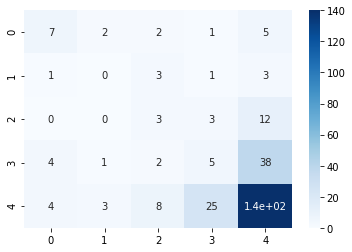

In [42]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues')

In [43]:
def pred(msg):
  msg=get_clean(msg)
  vec=vectorizer.transform([msg])
  prediction = clf.predict(vec)
  return print(prediction)

In [48]:
pred("Do you want order box, chat me!")

[5]


In [47]:
pred("Bad experience ever")

[1]


In [46]:
pred("I like this phone, original")

[4]
